# Import required packages/modules/functions:

When developing a workflow it is useful to import as many of the packages or specific functions from a package if you only need a few at the beginning. You will likely need to import more later and will import them separately. When this happens, to keep yourself organized, move the later imports to the beginning of the notebook once you are satisfied with your workflow.

In the following cell you can see that some packages are imported as a whole and given aliases. Some of these are field standards, such as `import numpy as np`. Others, are given aliases of personal preference (e.g., `import napari_segment_blobs_and_things_with_membranes as nsbatwm`). You can change these for what is most intuitive for you, but it is important to keep in mind that if you plan to share your workflow(s) with others for usage it is best for these aliases to be understandable by a general audience.

Below are links to the documentation of each of the packages/functions imported in the following cell. While their usage should become clear when stepping through the execution of each cell, I encourage you read the documentation as well:


### general python packages (APIs):

`os`: <https://docs.python.org/3/library/os.html>

`numpy`: <https://numpy.org/doc/stable/reference/index.html#reference>

`scipy.ndimage`: <https://docs.scipy.org/doc/scipy/reference/ndimage.html>

`matplotlib.pyplot`: <https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html>

### python image analysis (scikit-image) modules (APIs):

`skimage`: <https://scikit-image.org/docs/stable/api/api.html>

`skimage.data`: <https://scikit-image.org/docs/stable/api/skimage.data.html>

`skimage.io`: <https://scikit-image.org/docs/stable/api/skimage.io.html>

`skimage.measure`: <https://scikit-image.org/docs/stable/api/skimage.measure.html>

`skimage.morphology`: <https://scikit-image.org/docs/stable/api/skimage.morphology.html>

### napari plug-ins/packages (napari hub links):

`napari_segment_blobs_and_things_with_membranes`: <https://www.napari-hub.org/plugins/napari-segment-blobs-and-things-with-membranes>

`napari_process_points_and_surfaces`: <https://www.napari-hub.org/plugins/napari-process-points-and-surfaces#see-also>

`napari_skimage_regionprops`: <https://www.napari-hub.org/plugins/napari-skimage-regionprops>

### napari plug-ins/packages (github links):

`napari_segment_blobs_and_things_with_membranes`: <https://github.com/haesleinhuepf/napari-segment-blobs-and-things-with-membranes>

`napari_process_points_and_surfaces`: <https://github.com/haesleinhuepf/napari-process-points-and-surfaces#README.md>

`napari_skimage_regionprops`: <https://github.com/haesleinhuepf/napari-skimage-regionprops>


### pyclesperanto_prototype (github):

`pyclesperanto` is a python-based GPU acceleration package for image analysis. It makes many common image preprocessing or analysis actions possible with a single line of code that may otherwise require several lines involving for loops, logic conditions, etc... why reinvent the wheel? :)

`pyclesperanto_prototype`: <https://github.com/clEsperanto/pyclesperanto_prototype>

There is also a napari plug-in for pyclesperanto. The documentation can be found here: <<https://www.napari-hub.org/plugins/napari-pyclesperanto-assistant>.

If you have a powerful graphics card or an eGPU at your disposal, this is a highly advantageous package to become familair with to both speed up and simplify your workflows. In this notebook we will only use a few functions from this package, but I highly encourage you to follow the example notebooks on github for selecting and pushing data to a graphics card for processing if this is something that you believe will be useful for your workshop goals.

### stackview (github):

`stackview` is useful for being able to scroll through z-stacks in a jupyter notbook. See options for viewing single or multiple channels here: <https://github.com/haesleinhuepf/stackview>

In [1]:
import os
import numpy as np
from scipy.ndimage import center_of_mass
from datetime import datetime

from skimage.data import cells3d
from skimage.io import imshow, imsave

import napari_segment_blobs_and_things_with_membranes as nsbatwm

import pyclesperanto_prototype as cle
import stackview

%matplotlib inline

# Assign varible names to your data:

A small note when using the `skimage.data` module. These datasets are technically functions. Therefore, we need to call `cells3d` before we can treat it as an image (see next cell).

We also know from the documentation that the voxel resolution is $(z,y,x) = (0.29\mu m, 0.26 \mu m, 0.26\mu m)$.

In [2]:
image = cells3d()[21:53,:,:,:]
print('image size (z, c, y, x):', image.shape)

image size (z, c, y, x): (32, 2, 256, 256)


In the next two cells, we will split our image by channels and assign a variable name to each channel for downstream processing and analysis as they will be treated differently.

Note that the way each channel is visualized using `imshow` differs in the chosen colormap (`cmap`) and projection type (`.sum()`, `.min()` or `.max()`). You can 'play' with different colormaps chosen from here: <https://matplotlib.org/stable/gallery/color/colormap_reference.html> as well as deciding between using projections  with any of the spatial dimensions (`z,y,x`). 

Alternatively, you can check if the package `stackview` is installed in your environment so that you can scroll through the z-stack.

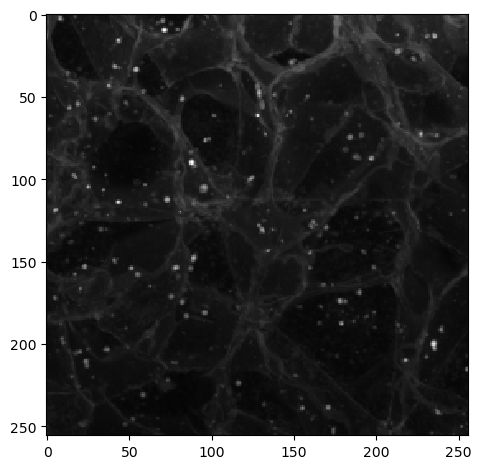

In [3]:
membrane = image[:,0,:,:]
imshow(membrane.max(axis = 0), cmap = 'gist_gray')

/Users/ryan/mambaforge/envs/devbio-napari-env/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


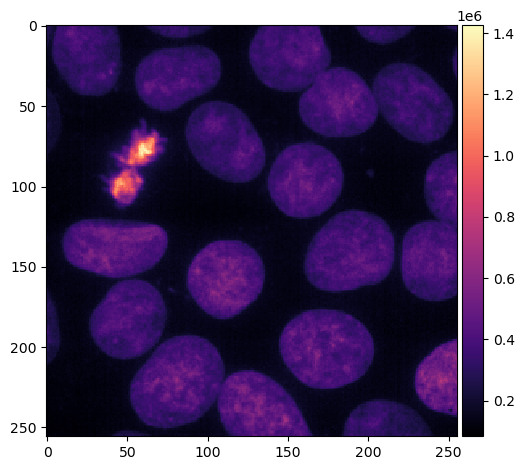

In [4]:
nuclei = image[:,1,...]
imshow(nuclei.sum(axis = 0), cmap = 'magma')

Q: <br>
What do you notice is different between the way that the channels are separated?

A: <br>
When indexing multidimensional arrays you can use a `:`s separated by `,` to indicate that you wish to keep all of the values in those dimensions. If you are working with an image that has 3+ dimensions and the single index you need occurs early in the dimensional order, you can use `...` to indicate that you wish to keep everything in all of the subsequent dimensions.

# Nuclear segmentation:

If you recall Joana's lecture on Monday, you may remember mention of Otsu thresholding. Here we will segment our nuclei using a combination of Otsu thresholding and voronoi labeling. After applying the Otsu threshold to generate a binary mask of the image foreground, a Voronoi diagram is created from the mask. The basic principal on a Voronoi diagram is to assign coordinates (pixels/voxels) to a label that corresponds to the closest seed. The seeds used in this method are the so called maxima of the foreground.

We will use the `napari_segment_blobs_and_things_with_membranes` of this method; however, you can find a comparison of it with the `pyclesperanto` implementation here: <https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20_image_segmentation/11_voronoi_otsu_labeling.html>

For those who are more mathematically minded (or simply curious!!), you may find the original paper from Otsu interesting: <https://ieeexplore.ieee.org/document/4310076>

### Gaussian blur:

As a small preprocessing step, we will apply a gaussian blur to the raw nuclei image.

Q: <br>
Is `cle.gaussian_blur()` a linear or nonlinear operation?

A: <br>
$_____________$

### Other notes:

Pay attention to the addtional variables passed to the functions, such as `footprint`. Do you understand them?

In [5]:
nuclei_gauss_blur_sigma_x = 2
nuclei_gauss_blur_sigma_y = 2
nuclei_gauss_blur_sigma_z = 2

blurred_nuclei = cle.gaussian_blur(nuclei, 
                                   sigma_x=nuclei_gauss_blur_sigma_x, 
                                   sigma_y=nuclei_gauss_blur_sigma_y, 
                                   sigma_z=nuclei_gauss_blur_sigma_z)

stackview.slice(blurred_nuclei)

In [6]:
nuclei_spot_sigma = 9
nuclei_outline_sigma = 2

labeled_nuclei = nsbatwm.voronoi_otsu_labeling(blurred_nuclei, 
                                               spot_sigma=nuclei_spot_sigma, 
                                               outline_sigma=nuclei_outline_sigma)
stackview.slice(labeled_nuclei)

# Membrane segmentation:

Here we will use the result of our nuclear segmentation to see a watershed segmentation of the membrane channel. First, we will create a 'seed image' that contains the center of mass of each labeled nucleus. This is a required input for `nsbatwm.seeded_watershed`.

The other input required for `nsbatwm.seeded_watershed` is of course the membrane image. This time, in addition to a guassian blur preprocessing step performed on the raw membrane input image, we will also do a background subtraction step.

In [7]:
nuclei_ids = np.arange(1, np.amax(labeled_nuclei)+1)

In [8]:
binary_nuclei = labeled_nuclei.astype(bool)

In [9]:
labeled_nuclei_centers_of_mass = np.rint(center_of_mass(binary_nuclei, labeled_nuclei, nuclei_ids)).astype(int)
labeled_nuclei_centers_of_mass

array([[ 11, 201, 173],
       [ 12,  73, 112],
       [ 10, 247, 207],
       [ 12, 238, 132],
       [ 13, 183,  51],
       [ 13, 220, 244],
       [ 13, 222,  82],
       [ 14,  18,  24],
       [ 13,  48, 227],
       [ 14, 158, 111],
       [ 11, 188,   2],
       [ 12,   1, 253],
       [ 13,  32,  80],
       [ 13,  97, 160],
       [ 14, 101, 247],
       [ 13, 142, 189],
       [ 14, 145, 240],
       [ 15,   3,  81],
       [ 14,  24, 254],
       [ 16,  49, 182],
       [ 15, 138,  42],
       [ 18,   4, 208],
       [ 17,  18, 151],
       [ 16,  88,  54]])

In [10]:
labeled_nuclei_seeds = np.zeros_like(labeled_nuclei)

for i in range(labeled_nuclei_centers_of_mass.shape[0]):
    z,y,x = labeled_nuclei_centers_of_mass[i]
    labeled_nuclei_seeds[z,y,x] = i+1

In [11]:
membrane_gauss_blur_sigma_x = 2
membrane_gauss_blur_sigma_y = 2
membrane_gauss_blur_sigma_z = 2

blurred_membrane = cle.gaussian_blur(membrane, 
                                     sigma_x=membrane_gauss_blur_sigma_x, 
                                     sigma_y=membrane_gauss_blur_sigma_y, 
                                     sigma_z=membrane_gauss_blur_sigma_z)

background_subtracted_membrane = nsbatwm.subtract_background(blurred_membrane)

In [12]:
membrane_seeded_segmentation = nsbatwm.seeded_watershed(background_subtracted_membrane, labeled_nuclei_seeds)
stackview.slice(membrane_seeded_segmentation)

# Saving your results:

When saving your results, it is important to either have a highly informative file name or also some sort of .txt or .csv log with all of the parameters you have selected that may change in future runs of the workflow. Here we will save the segmentation results as image files with today's date/time and create a small table where you can save all of your chosen parameter values with a name also including a matching date/time.

`pandas` is a package with the module `DataFrame` that allows for construction of readable and easily exportable tables. Please familiarize yourself with the module here: <https://pandas.pydata.org/docs/reference/frame.html>

Because automatically formatting reproducible `str` styles for saving files can be annoying, I have done it for you to the resolution of minutes and assigned each component to a variable :)

Reminder of what I said about moving late imports to the beginning of the workflow upon completion ;)

In [13]:
import pandas as pd

In [14]:
save_time = str(datetime.now().isoformat(timespec='minutes')).replace(':','-')
save_time

'2023-07-19T11-52'

In [15]:
save_path = os.getcwd()

membrane_save_str = '_seeded_watershed_membrane_segmentation.tif'
nuclei_save_str = '_voronoi_otsu_nuclei_segmentation.tif'

parameter_save_str = '_workflow_parameters_and_values.csv'

In [16]:
parameters = {'nuclei_gauss_blur_sigma_x': nuclei_gauss_blur_sigma_x,
              'nuclei_gauss_blur_sigma_y': nuclei_gauss_blur_sigma_y,
              'nuclei_gauss_blur_sigma_z': nuclei_gauss_blur_sigma_z,
              
              'nuclei_spot_sigma': nuclei_spot_sigma,
              'nuclei_outline_sigma': nuclei_outline_sigma,
              
              'membrane_gauss_blur_sigma_x': membrane_gauss_blur_sigma_x,
              'membrane_gauss_blur_sigma_y': membrane_gauss_blur_sigma_y,
              'membrane_gauss_blur_sigma_z': membrane_gauss_blur_sigma_z}

parameter_table = pd.DataFrame.from_dict(parameters, orient='index')
parameter_table

,0
nuclei_gauss_blur_sigma_x,2
nuclei_gauss_blur_sigma_y,2
nuclei_gauss_blur_sigma_z,2
nuclei_spot_sigma,9
nuclei_outline_sigma,2
membrane_gauss_blur_sigma_x,2
membrane_gauss_blur_sigma_y,2
membrane_gauss_blur_sigma_z,2


In [17]:
parameter_table.to_csv(os.path.join(save_path, save_time + parameter_save_str))

In [18]:
imsave(os.path.join(save_path, save_time + membrane_save_str), membrane_seeded_segmentation)
imsave(os.path.join(save_path, save_time + nuclei_save_str), labeled_nuclei)

/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_35036/3570194377.py:1: UserWarning: /Users/ryan/Desktop/jupyter_notebooks/zidas2023/2023-07-19T11-52_seeded_watershed_membrane_segmentation.tif is a low contrast image
  imsave(os.path.join(save_path, save_time + membrane_save_str), membrane_seeded_segmentation)
/var/folders/bc/qbrdgvy91nzfvx5r_zs_xny40000gp/T/ipykernel_35036/3570194377.py:2: UserWarning: /Users/ryan/Desktop/jupyter_notebooks/zidas2023/2023-07-19T11-52_voronoi_otsu_nuclei_segmentation.tif is a low contrast image
  imsave(os.path.join(save_path, save_time + nuclei_save_str), labeled_nuclei)


# Take home exercise:

Try to improve your membrane segmentation by using either `nsbatwm.seeded_watershed_with_mask` or `nsbatwm.local_minima_seeded_watershed`.

Alternatively, you can recreate the above workflow through the napari GUI and alter the input parameters there to see how the results change. For help recreating the workflow in the napari GUI, follow the github documentation for the modules provided at the start of the notebook :)